In [2]:
import s3fs
import pyarrow.parquet as pq
import geopandas as gp
import matplotlib.pyplot as plt
import duckdb

In [3]:
plt.style.use('ggplot')
conn = duckdb.connect()

In [4]:
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "https://minio.minio-tenant",
        "aws_access_key_id": "admin",
        "aws_secret_access_key": "6bd71ace-8866-407a-9bcc-714bc5753f18",
        "verify": "/home/rafael/K8s/minio/minio-certs/cert-authority.pem",
    }
)

In [5]:
stations = pq.read_table("dutrajardim-fi/tables/stations/osm_adm8.parquet", filesystem=fs)
ghcn = pq.read_table("dutrajardim-fi/tables/ghcn.parquet", filesystem=fs)

shapes_relations = pq.read_table("dutrajardim-fi/tables/shapes/osm/relations.parquet/adm=8", filesystem=fs)
shapes = pq.read_table("dutrajardim-fi/tables/shapes/osm/shapes.parquet/adm=8", filesystem=fs)

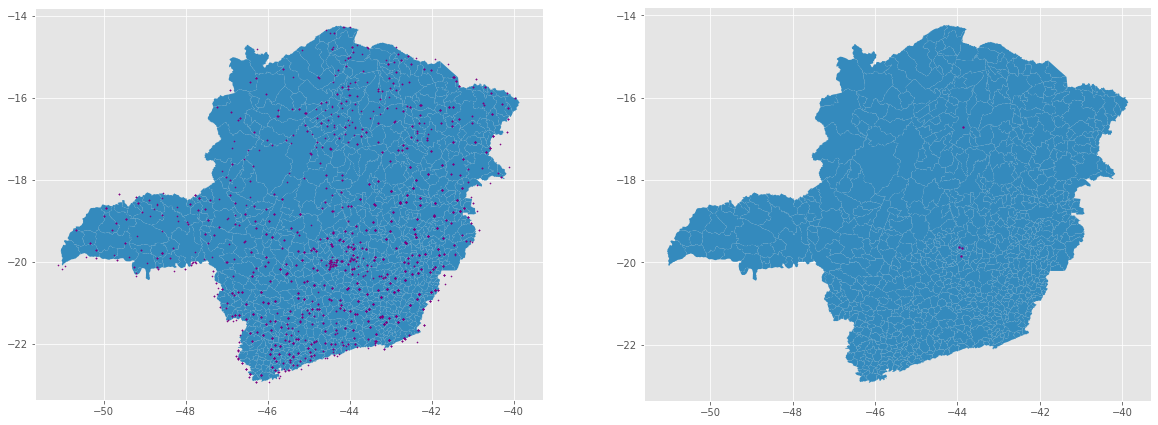

In [7]:
stations_mg = conn.execute("""
SELECT *
FROM stations
WHERE adm4_name = 'Minas Gerais'
""").df()

gdf_stations_mg = gp.GeoDataFrame(
    data=stations_mg.copy(),
    geometry=gp.GeoSeries.from_wkt(stations_mg['geometry'])
)

shapes_mg = conn.execute("""
SELECT geometry
FROM shapes
JOIN shapes_relations ON shapes.id = shapes_relations.id
WHERE adm4_name = 'Minas Gerais'
""").df()

gdf_shapes_mg = gp.GeoDataFrame(
    data=shapes_mg.copy(),
    geometry=gp.GeoSeries.from_wkt(shapes_mg['geometry'])
)

stations_mg_2022 = conn.execute("""
SELECT DISTINCT(station), FIRST(stations.geometry) as geometry
FROM ghcn
INNER JOIN stations ON ghcn.station = stations.id
WHERE 
    ghcn.year = 2022 AND
    adm4_name = 'Minas Gerais'
GROUP BY station
""").df()

gdf_stations_mg_2022 = gp.GeoDataFrame(
    data=stations_mg_2022.copy(),
    geometry=gp.GeoSeries.from_wkt(stations_mg_2022['geometry'])
)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

gdf_shapes_mg.plot(ax=ax[0])
gdf_shapes_mg.plot(ax=ax[1])

gdf_stations_mg.plot(ax=ax[0], color='purple', markersize=1.2)
gdf_stations_mg_2022.plot(ax=ax[1], color='purple', markersize=3)

plt.show()